In [1]:
#import libraries
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model, datasets,metrics
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import Dense, Dropout, Flatten,BatchNormalization, Conv2D, MaxPooling2D

In [2]:
# Set the path to the data directory
data_address = os.path.join(os.getcwd(),'..', 'Data')
image_address = os.path.join(data_address, 'Coronahack-Chest-XRay-Dataset', 'Coronahack-Chest-XRay-Dataset')
training_label = pd.read_csv(os.path.join(data_address, 'training_label.csv'))
testing_label = pd.read_csv(os.path.join(data_address, 'testing_label.csv'))
# Get the image paths
train_images_normal = [os.path.join(image_address, 'train', filename) for filename in training_label[training_label.Label == 'Normal'].X_ray_image_name.tolist()]
train_images_sick = [os.path.join(image_address, 'train', filename) for filename in training_label[training_label.Label == 'Pnemonia'].X_ray_image_name.tolist()]
test_images_normal = [os.path.join(image_address, 'test', filename) for filename in testing_label[testing_label.Label == 'Normal'].X_ray_image_name.tolist()]
test_images_sick = [os.path.join(image_address, 'test', filename) for filename in testing_label[testing_label.Label == 'Pnemonia'].X_ray_image_name.tolist()]


In [3]:
# Function for plotting images
plots_dir = "../plots"
os.makedirs(plots_dir,exist_ok=True)
#plot accuracy curves
def plot_fig(i, history, model):
    fig = plt.figure()
    plt.plot(history.history['val_accuracy'],'b',linewidth=3.0, label='validation')
    plt.plot(history.history['accuracy'],'r',linewidth=3.0,label='training')
    plt.legend(loc=0)
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.grid(True)
    plt.title("Model Accuracy" + str(model))
    plt.show()
    fig.savefig(os.path.join(plots_dir, str(i)+'-accuracy.jpg'))
    plt.close(fig)

In [4]:
# modeling parameters
train_arrays = []
size = (256, 256)
batch_size = 32

In [5]:
# Create an ImageDataGenerator and do Image Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,        # Degree range for random rotations
    width_shift_range=0.2,    # Range for horizontal shift
    height_shift_range=0.2,   # Range for vertical shift
    shear_range=0.2,          # Shear intensity range
    zoom_range=0.2,           # Range for random zoom
    horizontal_flip=True,     # Randomly flip images horizontally
    vertical_flip=False       # Do not flip images vertically
)


In [6]:
# Load the training data
training_label.dropna()
for x in training_label['X_ray_image_name']:
    try:
        img_path = os.path.join(image_address, 'train', x)
        img = image.load_img(img_path, target_size=size)
        img_array = image.img_to_array(img)
        train_arrays.append(img_array)
    except Exception as e:
        print(f"Error loading image: {img_path}")
        # Handle the exception or skip the image if necessary

In [7]:
# Convert train_arrays and label to NumPy arrays
train_images = np.array(train_arrays)
label_mapping = {"Pnemonia": 1, "Normal": 0}
label = training_label['Label'].map(label_mapping)
train_images = train_images.astype('float32') / 255.0


In [8]:
# Split the data into training and validation sets
augmented_images = datagen.flow(train_images, label, batch_size=batch_size)
augmented_train_images = []
augmented_labels = []

for images, labels in augmented_images:
    augmented_train_images.append(images)
    augmented_labels.append(labels)
    if len(augmented_train_images) >= len(train_images) / batch_size:
        break

augmented_train_images = np.concatenate(augmented_train_images)
augmented_labels = np.concatenate(augmented_labels)


In [9]:
# Split the data into training and validation sets
train_images = np.concatenate((train_images, augmented_train_images))
labels = np.concatenate((label, augmented_labels))

train_images, val_images, train_labels, val_labels = train_test_split(train_images, labels, test_size=0.2, random_state=42)
final_train_images, val_images, final_train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)



In [10]:
# Define the input size
epochs = 50
batch_size = 32
input_shape = (256, 256, 3)
num_classes = 2
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
validation_data = (val_images, val_labels)


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense

model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [12]:
from tensorflow.keras.utils import to_categorical
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# validation set
final_train_labels_encoded = to_categorical(final_train_labels, num_classes=2)
val_labels_encoded = to_categorical(val_labels, num_classes=2)
validation_data = (val_images, val_labels_encoded)

In [13]:
history = model.fit(final_train_images, final_train_labels_encoded, batch_size=batch_size, epochs=epochs, validation_data=validation_data, callbacks=[callbacks])


Epoch 1/50


2023-05-23 14:02:42.357894: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


212/212 [==============================] - 152s 702ms/step - loss: 45.3643 - accuracy: 0.6253 - val_loss: 2.1138 - val_accuracy: 0.7358
Epoch 2/50
212/212 [==============================] - 140s 658ms/step - loss: 7.7080 - accuracy: 0.6387 - val_loss: 1.2346 - val_accuracy: 0.2589
Epoch 3/50
212/212 [==============================] - 140s 659ms/step - loss: 1.0954 - accuracy: 0.7301 - val_loss: 0.6077 - val_accuracy: 0.7063
Epoch 4/50
212/212 [==============================] - 142s 671ms/step - loss: 0.6736 - accuracy: 0.7358 - val_loss: 0.5803 - val_accuracy: 0.7364
Epoch 5/50
212/212 [==============================] - 138s 650ms/step - loss: 0.5903 - accuracy: 0.7443 - val_loss: 0.5789 - val_accuracy: 0.7364
Epoch 6/50
212/212 [==============================] - 146s 689ms/step - loss: 0.5871 - accuracy: 0.7459 - val_loss: 0.5754 - val_accuracy: 0.7364
Epoch 7/50
212/212 [==============================] - 148s 694ms/step - loss: 0.7149 - accuracy: 0.7453 - val_loss: 0.5770 - val_accur

Text(0.5, 1.0, 'Loss Curves')

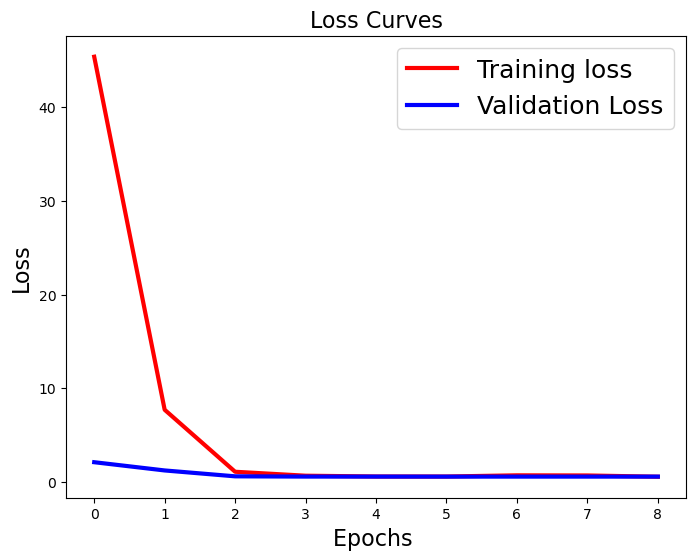

In [14]:
# plot loss curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

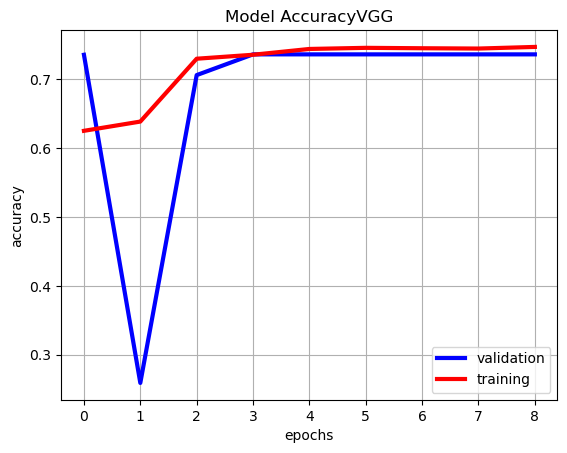

In [15]:
# plot accuracy
plot_fig(5, history, 'VGG')

53/53 [==============================] - 14s 269ms/step
Accuracy:  0.7364066193853428

Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       446
           1       0.74      1.00      0.85      1246

    accuracy                           0.74      1692
   macro avg       0.37      0.50      0.42      1692
weighted avg       0.54      0.74      0.62      1692



/Users/kelvin/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kelvin/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kelvin/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

53/53 [==============================] - 15s 285ms/step
Confusion Matrix:
[[   0  446]
 [   0 1246]]
53/53 [==============================] - 13s 251ms/step


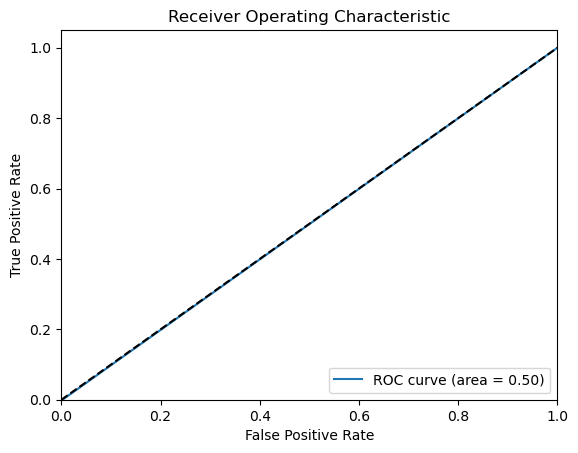

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


class_names = ["Normal", "Pneumonia"]
# Predict classes
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Predict classes
y_pred = model.predict(val_images)
y_pred_classes = np.argmax(y_pred, axis=1)

# Print Accuracy, F1 Score, Precision, Recall
print("Accuracy: ", accuracy_score(val_labels, y_pred_classes))
print('\nClassification Report')
print(classification_report(val_labels, y_pred_classes))

# Confusion Matrix
from sklearn.metrics import confusion_matrix

# Predict classes
y_pred = model.predict(val_images)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(val_labels, y_pred_classes)

# Print the confusion matrix
print('Confusion Matrix:')
print(cm)


# ROC Curve 
from sklearn.metrics import roc_curve, auc

# Predict probabilities
y_pred_probs = model.predict(val_images)

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(val_labels, y_pred_probs[:, 1])
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
